In [2]:
import cobra
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json

In [4]:
model = cobra.io.read_sbml_model("model_files/ProchlorococcusMED4+PHM2v1.xml")
amgs = json.loads(open("model_files/amg_reactions.json").read())
manual_relabels = json.loads(open("model_files/subsystem_alias.json").read())

In [10]:
def plot_impact_graph(ax, fva_healthy, fva_phm2, amgs, cut=0.1, sort=True):
    diffs = fva_phm2 - fva_healthy
    if sort:
        diff_s = sorted(
            diffs.iterrows(),
            key=lambda x: -np.abs(
                (fva_healthy.loc[x[0], "maximum"] + fva_healthy.loc[x[0], "minimum"])
                / 2
                - (fva_phm2.loc[x[0], "maximum"] + fva_phm2.loc[x[0], "minimum"]) / 2
            )
            if x[0] != "PHM2_prodrxn_VN"
            else 1,
        )
    else:
        diff_s = diffs.iterrows()
    barw = 0.85
    ylabs = []
    scales = []
    row = 0
    for i, (dind, (dmin, dmax)) in enumerate(diff_s):
        r_healthy = fva_healthy[fva_healthy.index == dind]
        if r_healthy.empty:
            continue
        hmin = float(r_healthy["minimum"].iloc[0])
        hmax = float(r_healthy["maximum"].iloc[0])
        hwidth = hmax - hmin

        r_infected = fva_phm2[fva_phm2.index == dind]
        imin = float(r_infected["minimum"].iloc[0])
        imax = float(r_infected["maximum"].iloc[0])
        iwidth = imax - imin

        normalization = max([np.abs(hmin), np.abs(hmax), np.abs(imin), np.abs(imax)])

        if normalization < cut:
            continue

        hmin /= normalization
        hmax /= normalization
        hwidth /= normalization
        imin /= normalization
        imax /= normalization
        iwidth /= normalization
        dmin /= normalization
        dmax /= normalization

        hmid = (hmin + hmax) / 2
        imid = (imin + imax) / 2

        if np.abs(hmid - imid) < cut:
            continue

        ax.broken_barh(
            [(hmin, hwidth)],
            (-row - 0.5, barw),
            color="b",
            alpha=0.2,
        )
        ax.plot(hmid, -row, "bo", alpha=0.5)

        ax.broken_barh(
            [(imin, iwidth)],
            (-row - 0.5, barw),
            color="r",
            alpha=0.2,
        )
        ax.plot(imid, -row, "ro", alpha=0.5)

        row += 1
        ss = healthy.reactions.get_by_id(dind).subsystem
        # nm = healthy.reactions.get_by_id(dind).name
        nm = dind
        if not ss:
            ss = "Unspecified"
        if ss in manual_relabels:
            ss = manual_relabels[ss]
        ylabs.append(f"{'*' if nm in amgs else ''}{nm} ({ss})")
        scales.append(f"x{normalization:.2f} " + r"mmol gDW$^{-1}$h$^{-1}$")
    ax.set_yticks([-x for x in range(len(ylabs))])
    ax.set_yticklabels(ylabs)
    ax2 = ax.twinx()
    ax2.set_yticks([-x for x in range(len(ylabs))])
    ax2.set_yticklabels(scales)
    ax.set_ylim([-len(ylabs), 1])
    ax2.set_ylim([-len(ylabs), 1])
    ax.grid(axis="both")
    ax.set_xlabel("FVA Ranges (normalized)")
    ax.legend(
        ["Healthy Range", "Healthy Midpoint", "Infected Range", "Infected Midpoint"],
        ncols=2,
        loc="upper right",
    )

In [6]:
with model as healthy:
    fva_healthy = cobra.flux_analysis.flux_variability_analysis(healthy)
with model as phm2:
    phm2.objective = phm2.reactions.PHM2_prodrxn_VN.flux_expression
    fva_phm2_no_amg = cobra.flux_analysis.flux_variability_analysis(phm2)
print(fva_healthy[fva_healthy.index == "BIOMASS"])
print(fva_healthy[fva_healthy.index == "PHM2_prodrxn_VN"])
print("-" * 80)
print(fva_phm2_no_amg[fva_phm2_no_amg.index == "BIOMASS"])
print(fva_phm2_no_amg[fva_phm2_no_amg.index == "PHM2_prodrxn_VN"])

          minimum   maximum
BIOMASS  0.098462  0.098462
                 minimum       maximum
PHM2_prodrxn_VN      0.0  1.147462e-13
--------------------------------------------------------------------------------
         minimum       maximum
BIOMASS      0.0 -3.601452e-13
                  minimum   maximum
PHM2_prodrxn_VN  0.183896  0.183896


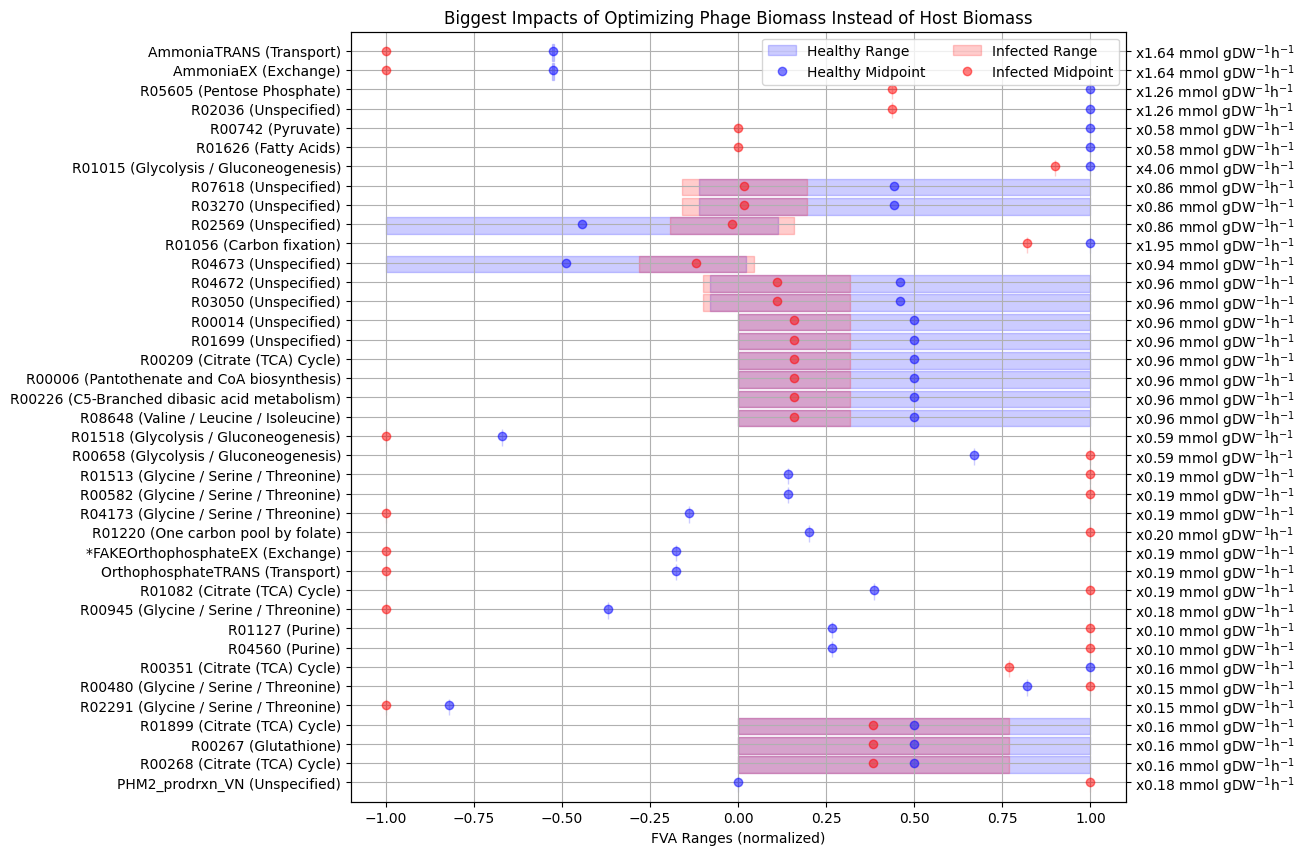

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_impact_graph(ax, fva_healthy, fva_phm2_no_amg, amgs, cut=0.1)
ax.set_title("Biggest Impacts of Optimizing Phage Biomass Instead of Host Biomass")
# fig.savefig("biomass_fva_comparison.png", bbox_inches="tight")
plt.show()

In [8]:
with model as healthy:
    fva_healthy_amg = cobra.flux_analysis.flux_variability_analysis(
        healthy, list(amgs.keys())
    )
with model as phm2:
    phm2.objective = phm2.reactions.PHM2_prodrxn_VN.flux_expression
    fva_phm2_no_amg_amg = cobra.flux_analysis.flux_variability_analysis(
        phm2, list(amgs.keys())
    )

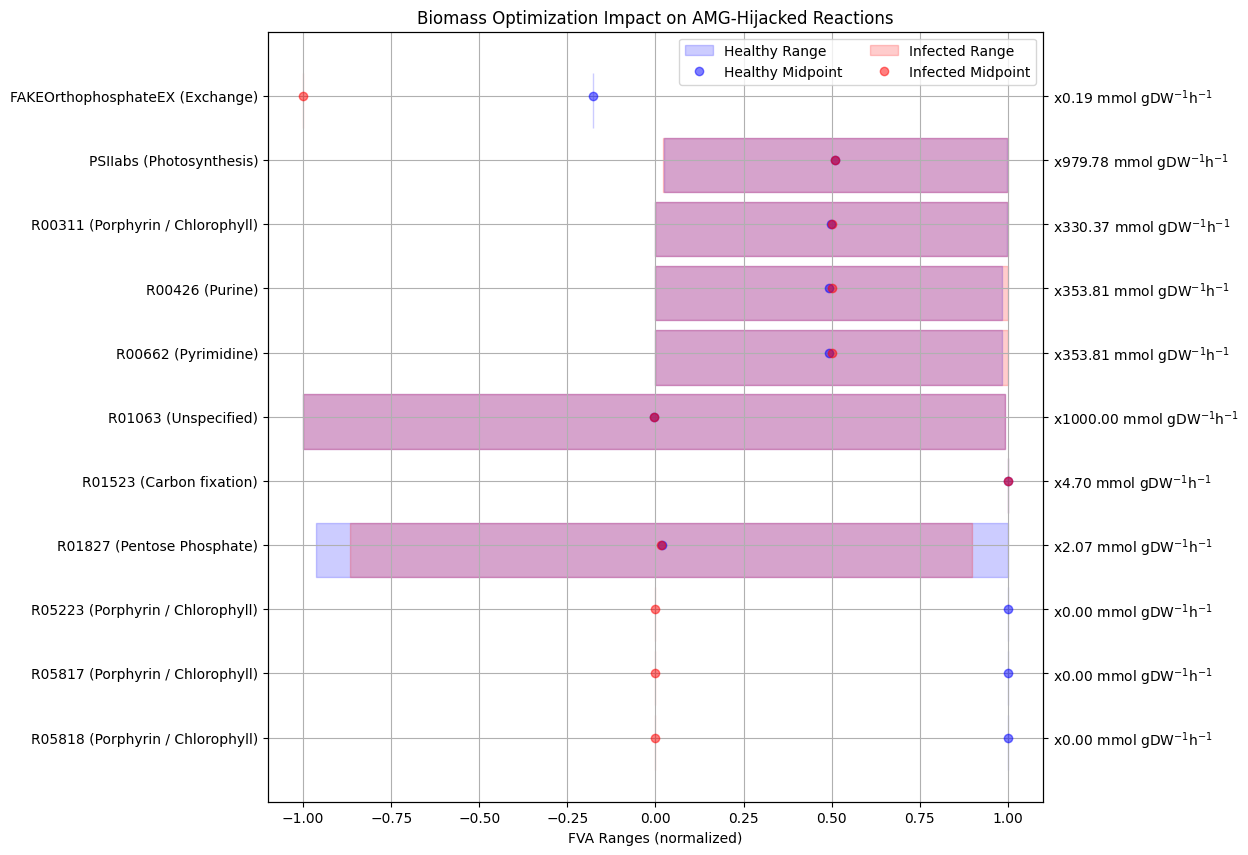

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_impact_graph(ax, fva_healthy_amg, fva_phm2_no_amg_amg, [], cut=0, sort=False)
ax.set_title("Biomass Optimization Impact on AMG-Hijacked Reactions")
plt.show()

In [13]:
with model as healthy:
    fva_healthy_amg2 = cobra.flux_analysis.flux_variability_analysis(
        healthy,
        list(amgs.keys()),
        fraction_of_optimum=0.5,
    )
with model as phm2:
    phm2.objective = phm2.reactions.PHM2_prodrxn_VN.flux_expression
    fva_phm2_no_amg_amg2 = cobra.flux_analysis.flux_variability_analysis(
        phm2,
        list(amgs.keys()),
        fraction_of_optimum=0.5,
    )

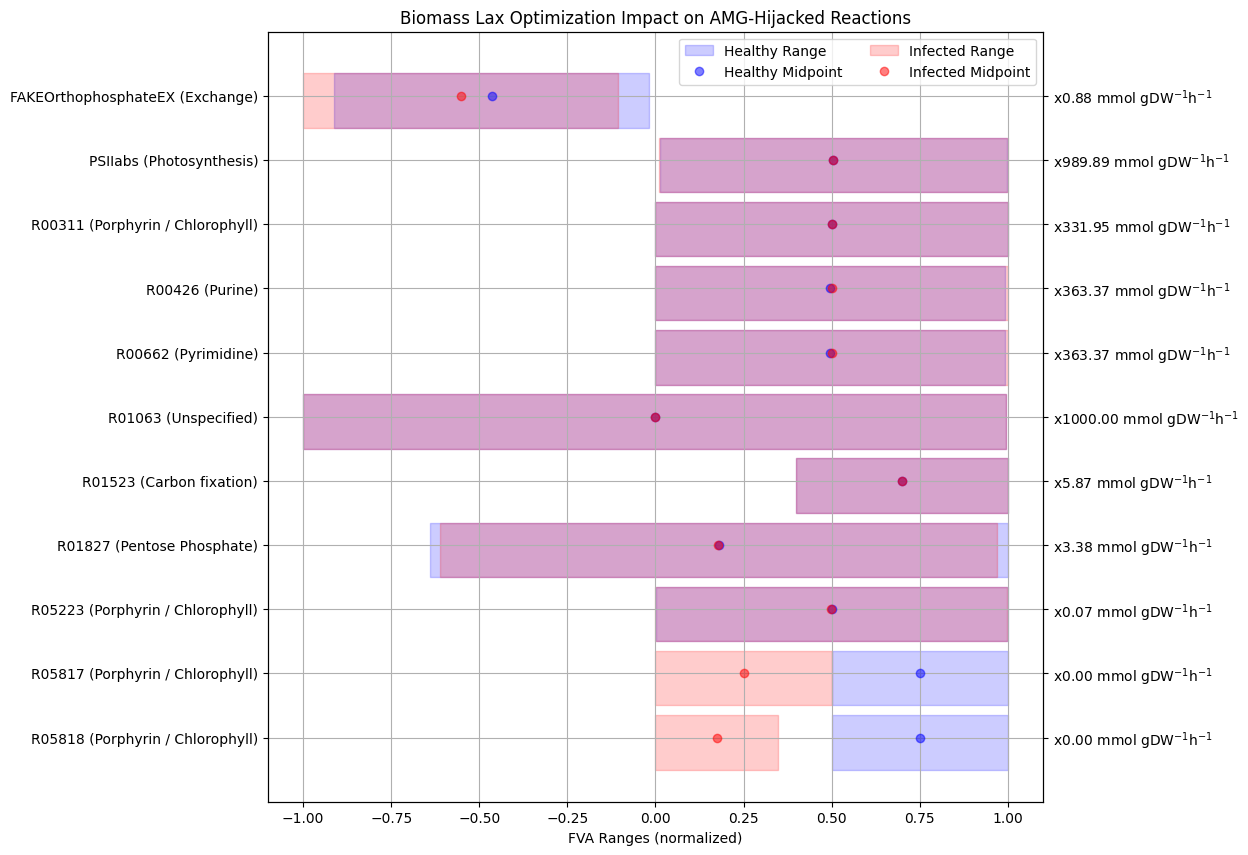

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_impact_graph(ax, fva_healthy_amg2, fva_phm2_no_amg_amg2, [], cut=0, sort=False)
ax.set_title("Biomass Lax Optimization Impact on AMG-Hijacked Reactions")
plt.show()

In [15]:
# PSIIabs raw increase         	[-4.87e-15, +1.00e+03]
# R00311 raw increase         	[+0.00e+00, +3.33e+02]
# R00426 raw increase         	[+0.00e+00, +3.73e+02]
# R00662 raw increase         	[+0.00e+00, +3.73e+02]
# R01063 absolute decrease    	[-1.00e+03, +1.00e+03]
# R01523 absolute decrease    	[+0.00e+00, +7.05e+00]
# R01827 absolute increase    	[-2.35e+00, +4.70e+00]
# R05223 raw increase         	[+0.00e+00, +1.49e-01]
# R05817 raw increase         	[+0.00e+00, +4.14e-07]
# R05818 raw increase         	[+0.00e+00, +4.14e-07]

factor = 0.99
amg_new_vals = {
    "FAKEOrthophosphateEX": fva_phm2_no_amg_amg[
        fva_phm2_no_amg_amg.index == "FAKEOrthophosphateEX"
    ]["minimum"].iloc[0]
    * factor,
    "PSIIabs": fva_healthy[fva_healthy.index == "PSIIabs"]["maximum"].iloc[0] * factor,
    "R00311": fva_healthy[fva_healthy.index == "R00311"]["maximum"].iloc[0] * factor,
    "R00426": fva_healthy[fva_healthy.index == "R00426"]["maximum"].iloc[0] * factor,
    "R00662": fva_healthy[fva_healthy.index == "R00662"]["maximum"].iloc[0] * factor,
    "R01063": 0.0,
    "R01523": fva_healthy[fva_healthy.index == "R00662"]["minimum"].iloc[0]
    * (1 - factor),
    "R01827": fva_healthy[fva_healthy.index == "R01827"]["maximum"].iloc[0] * factor,
    "R05223": fva_healthy[fva_healthy.index == "R05223"]["maximum"].iloc[0] * factor,
    "R05817": fva_healthy[fva_healthy.index == "R05817"]["maximum"].iloc[0] * factor,
    "R05818": fva_healthy[fva_healthy.index == "R05818"]["maximum"].iloc[0] * factor,
}

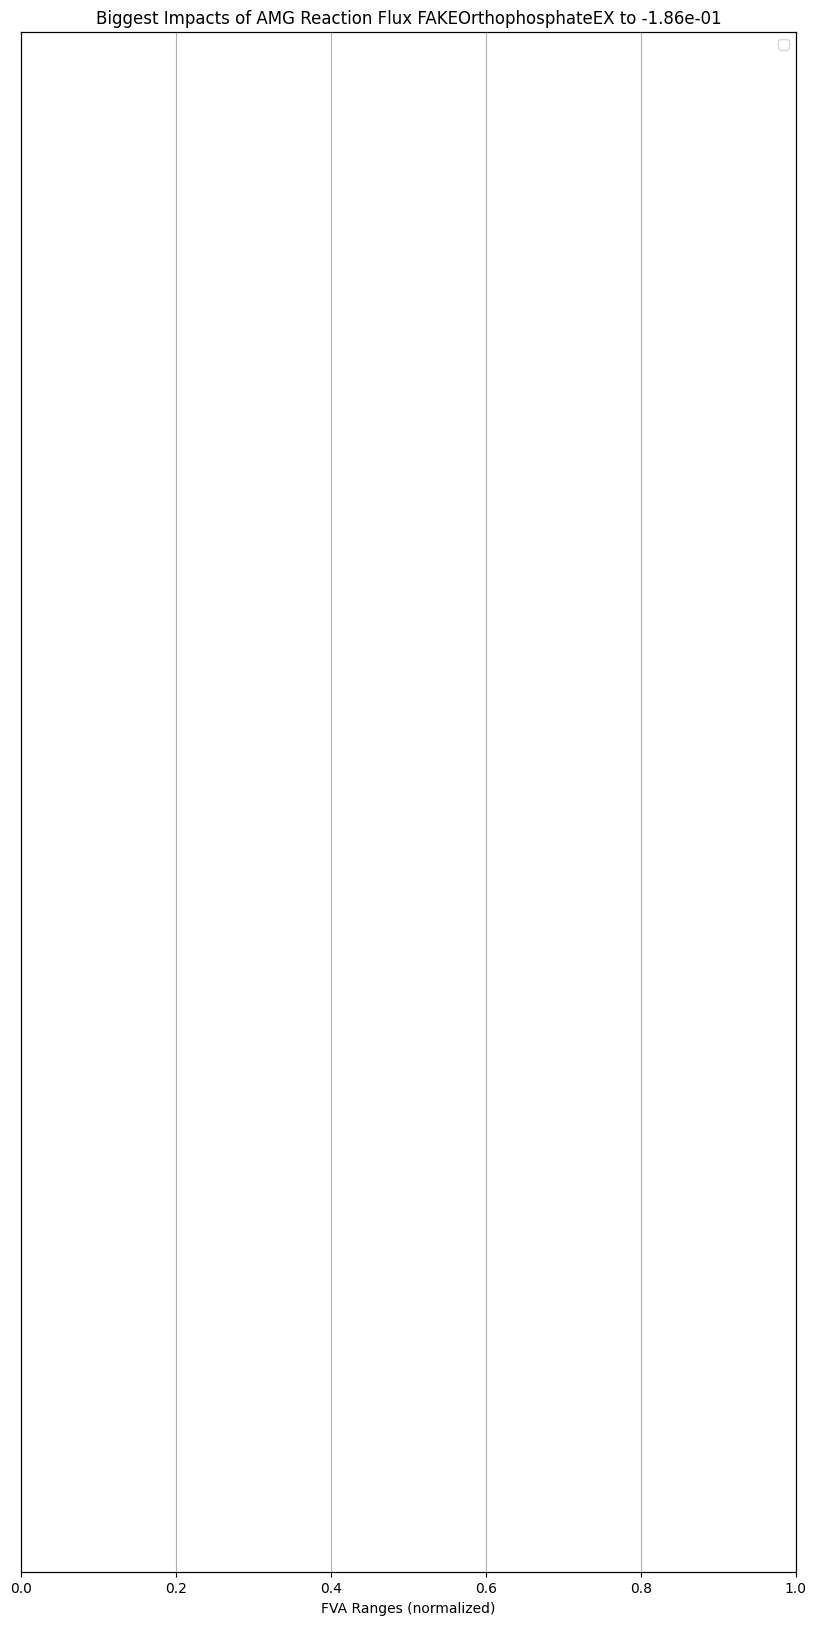

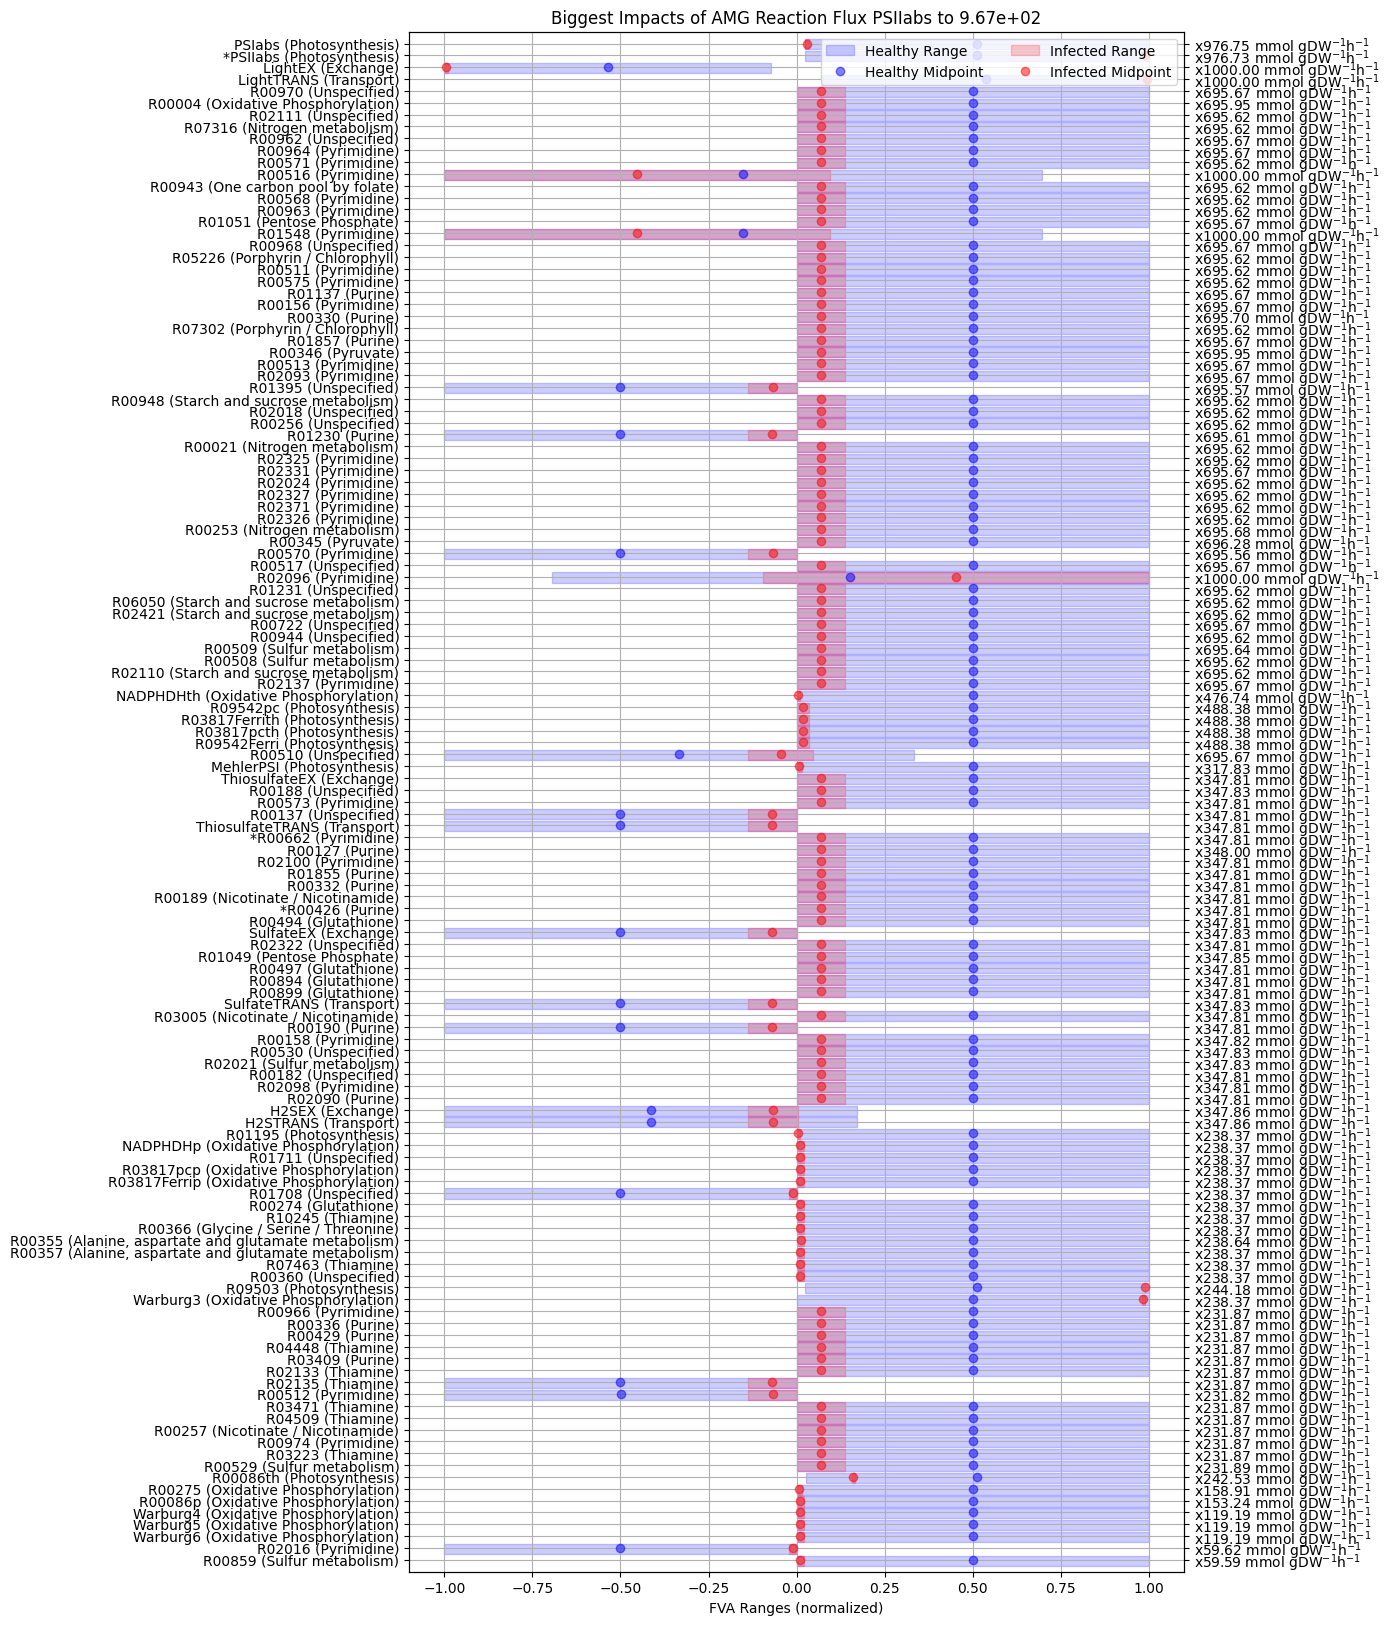

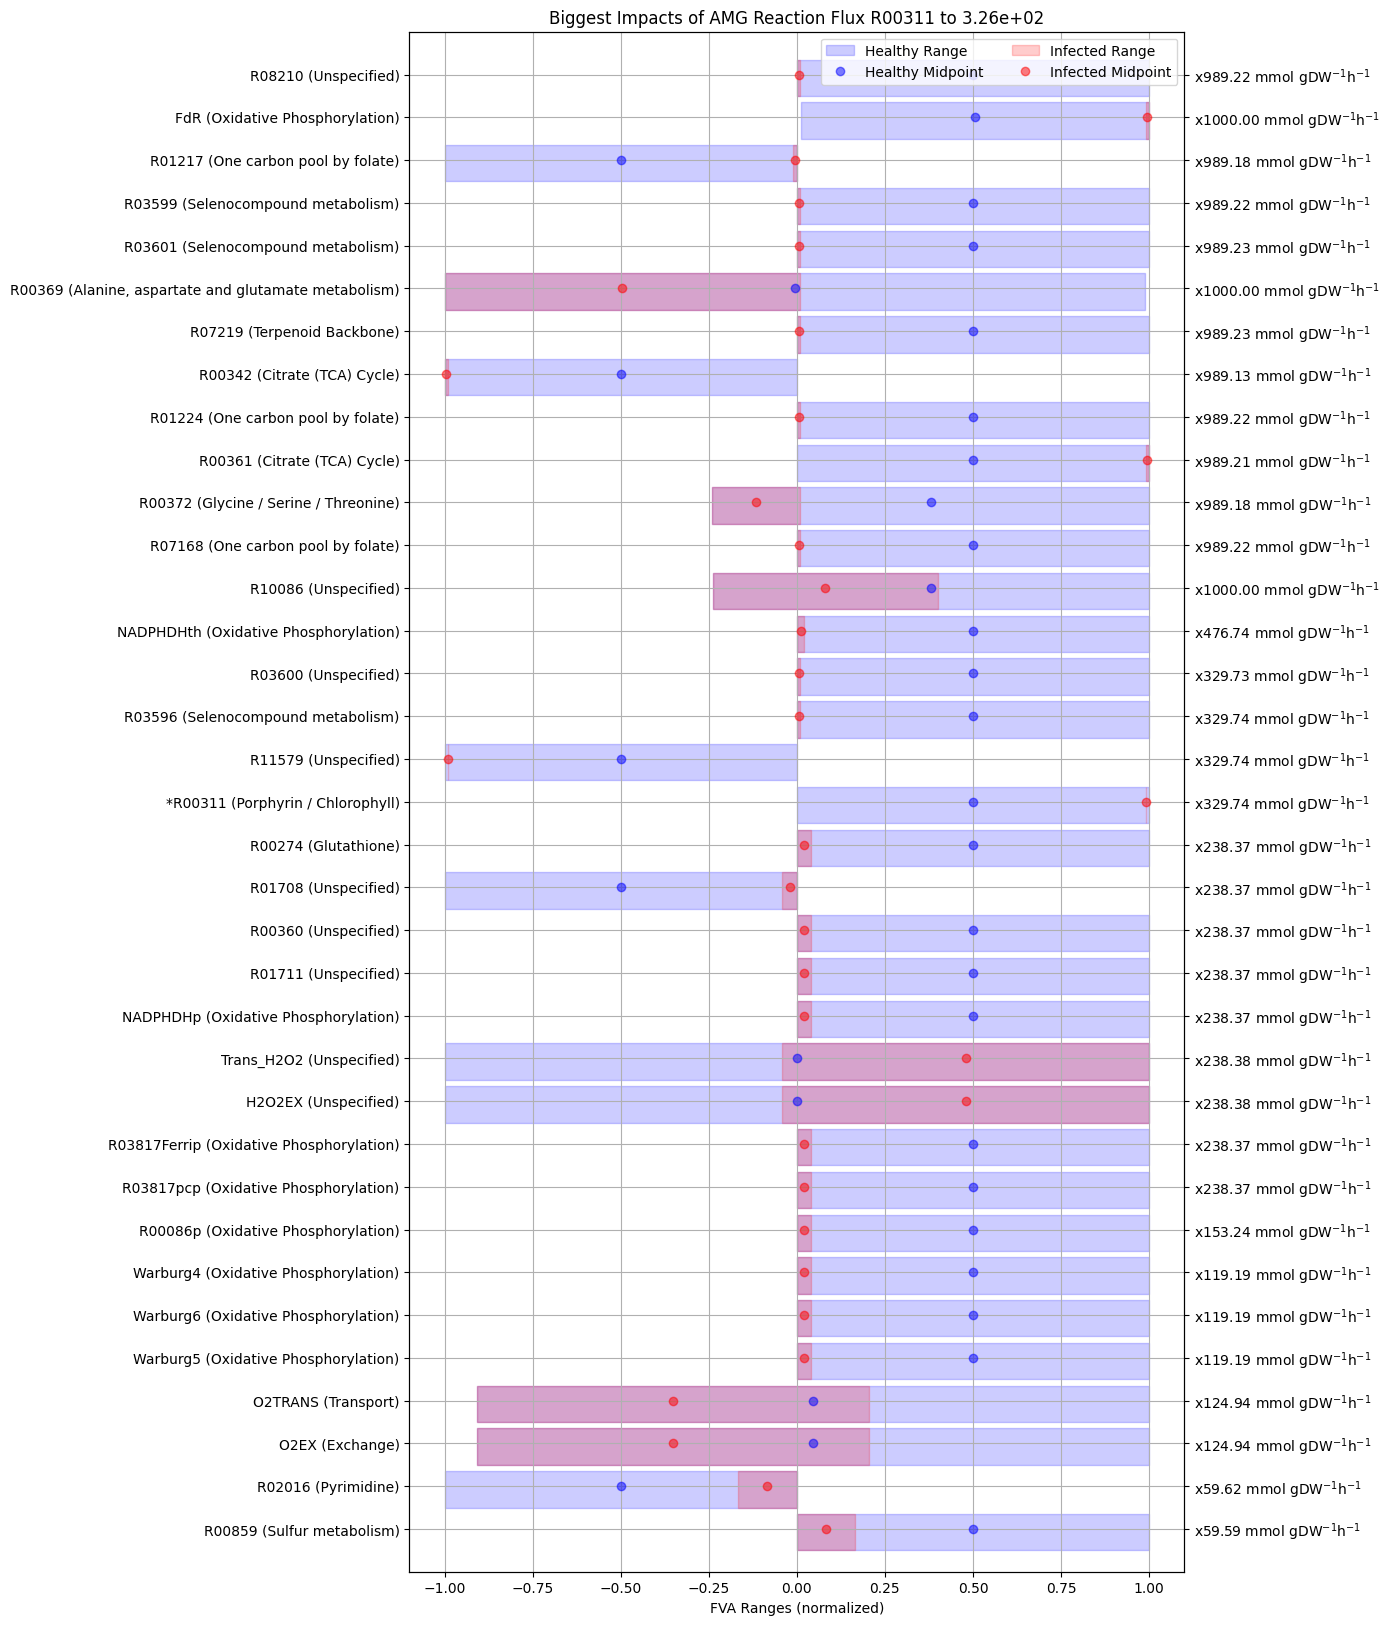

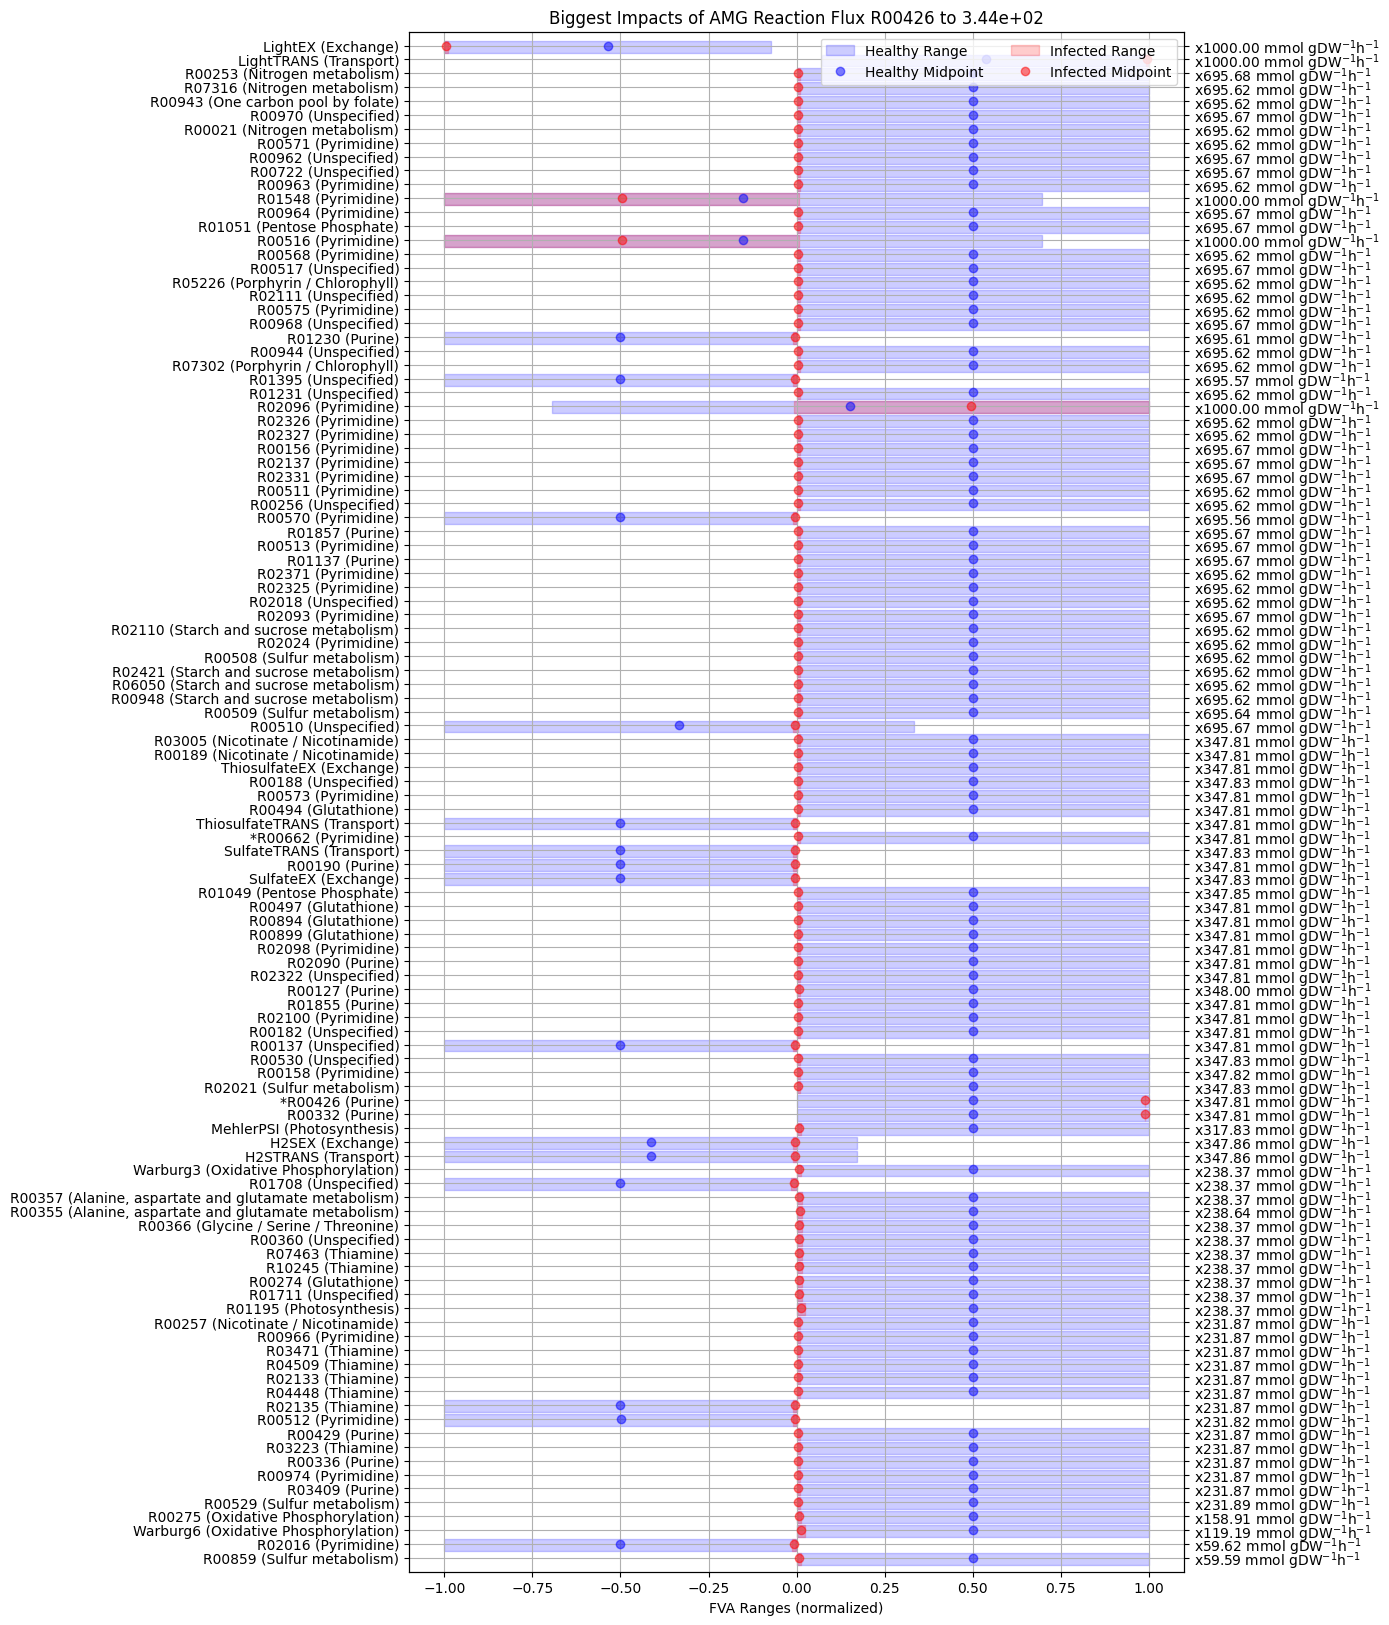

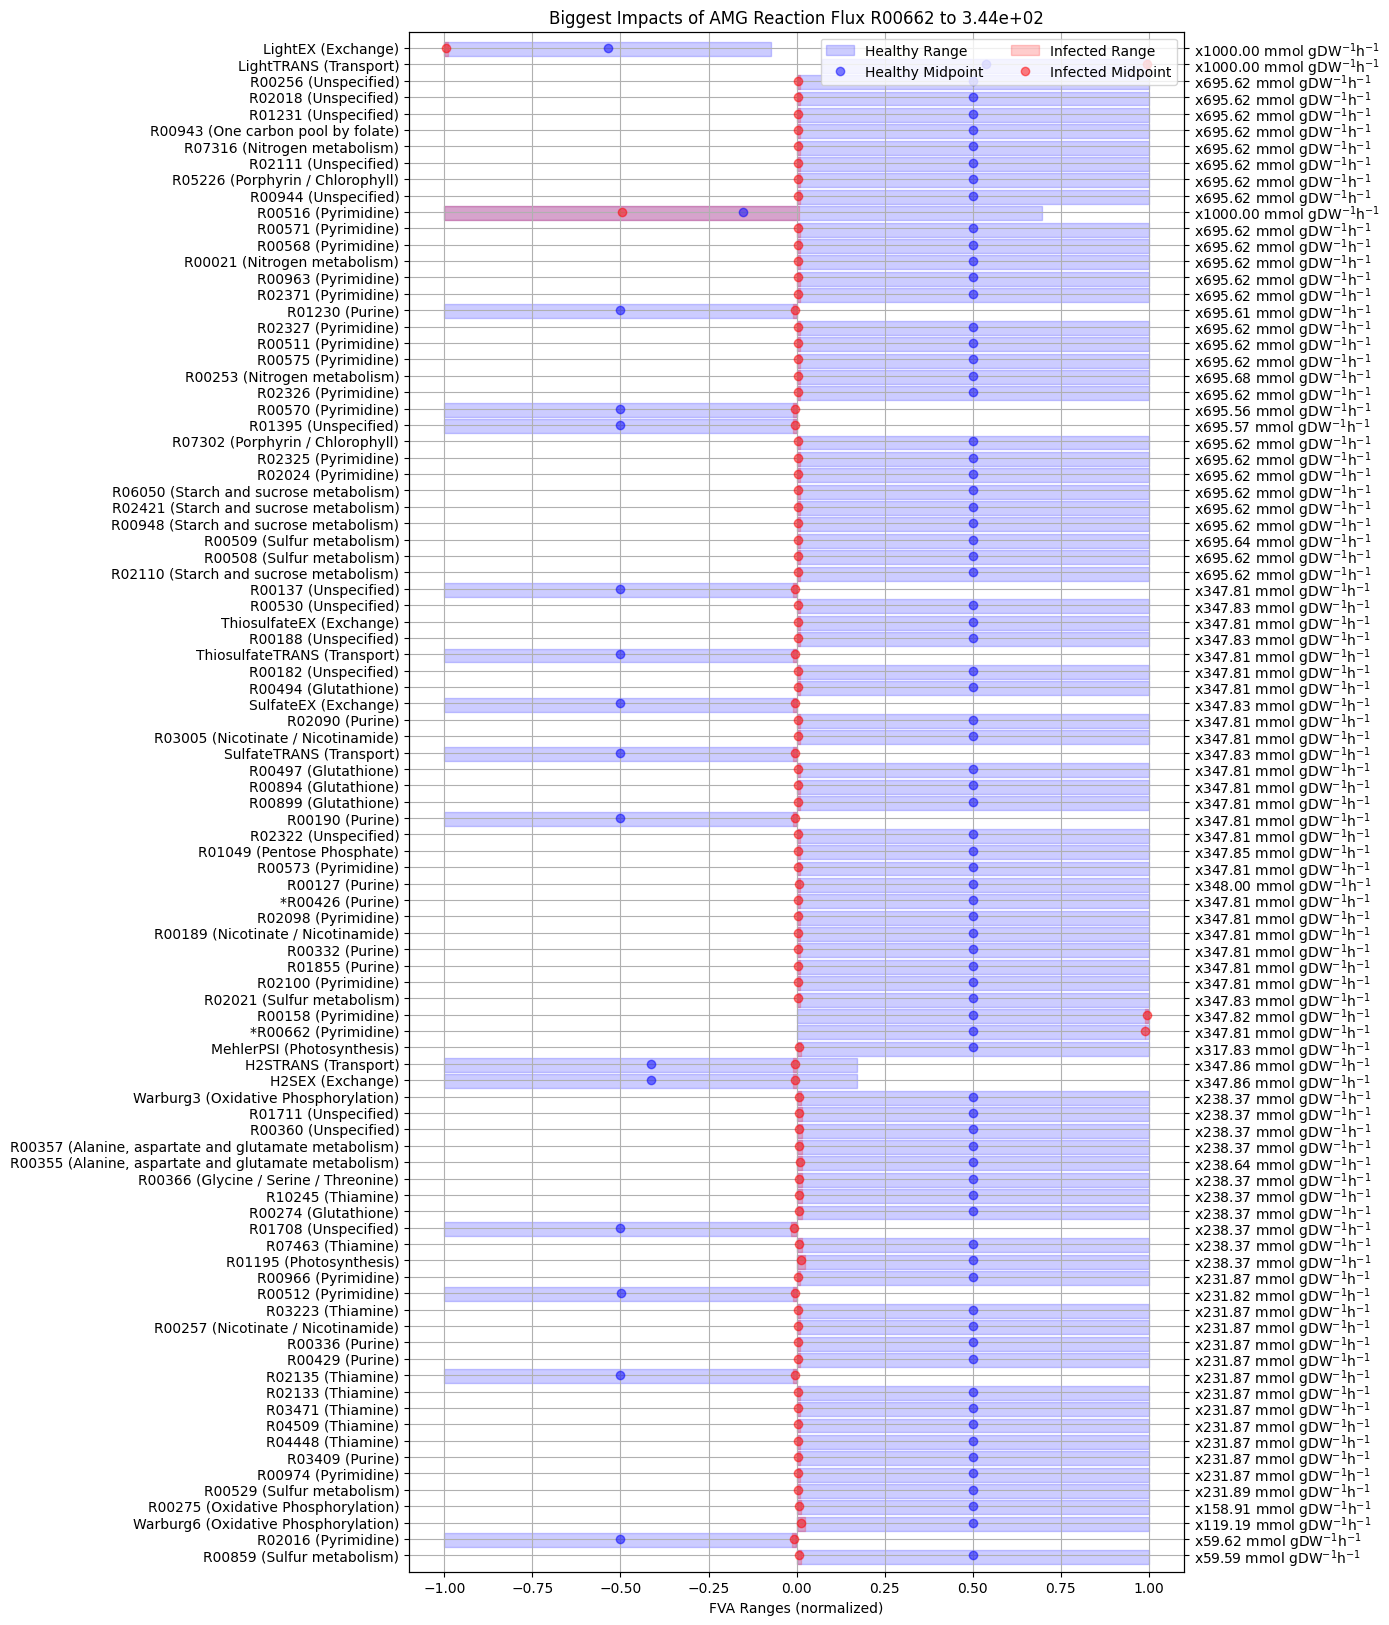

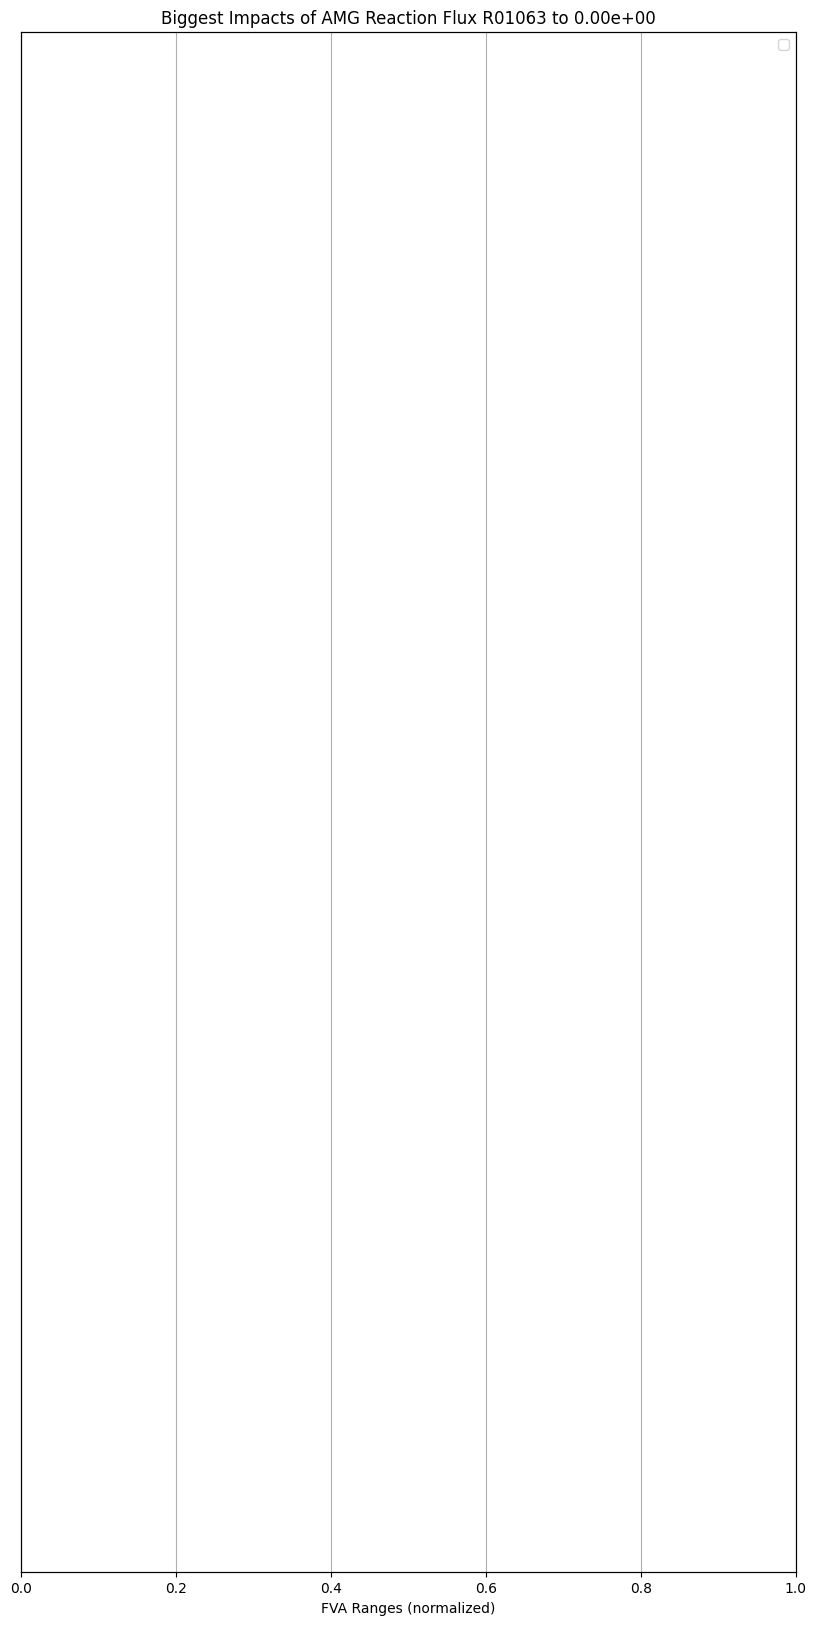

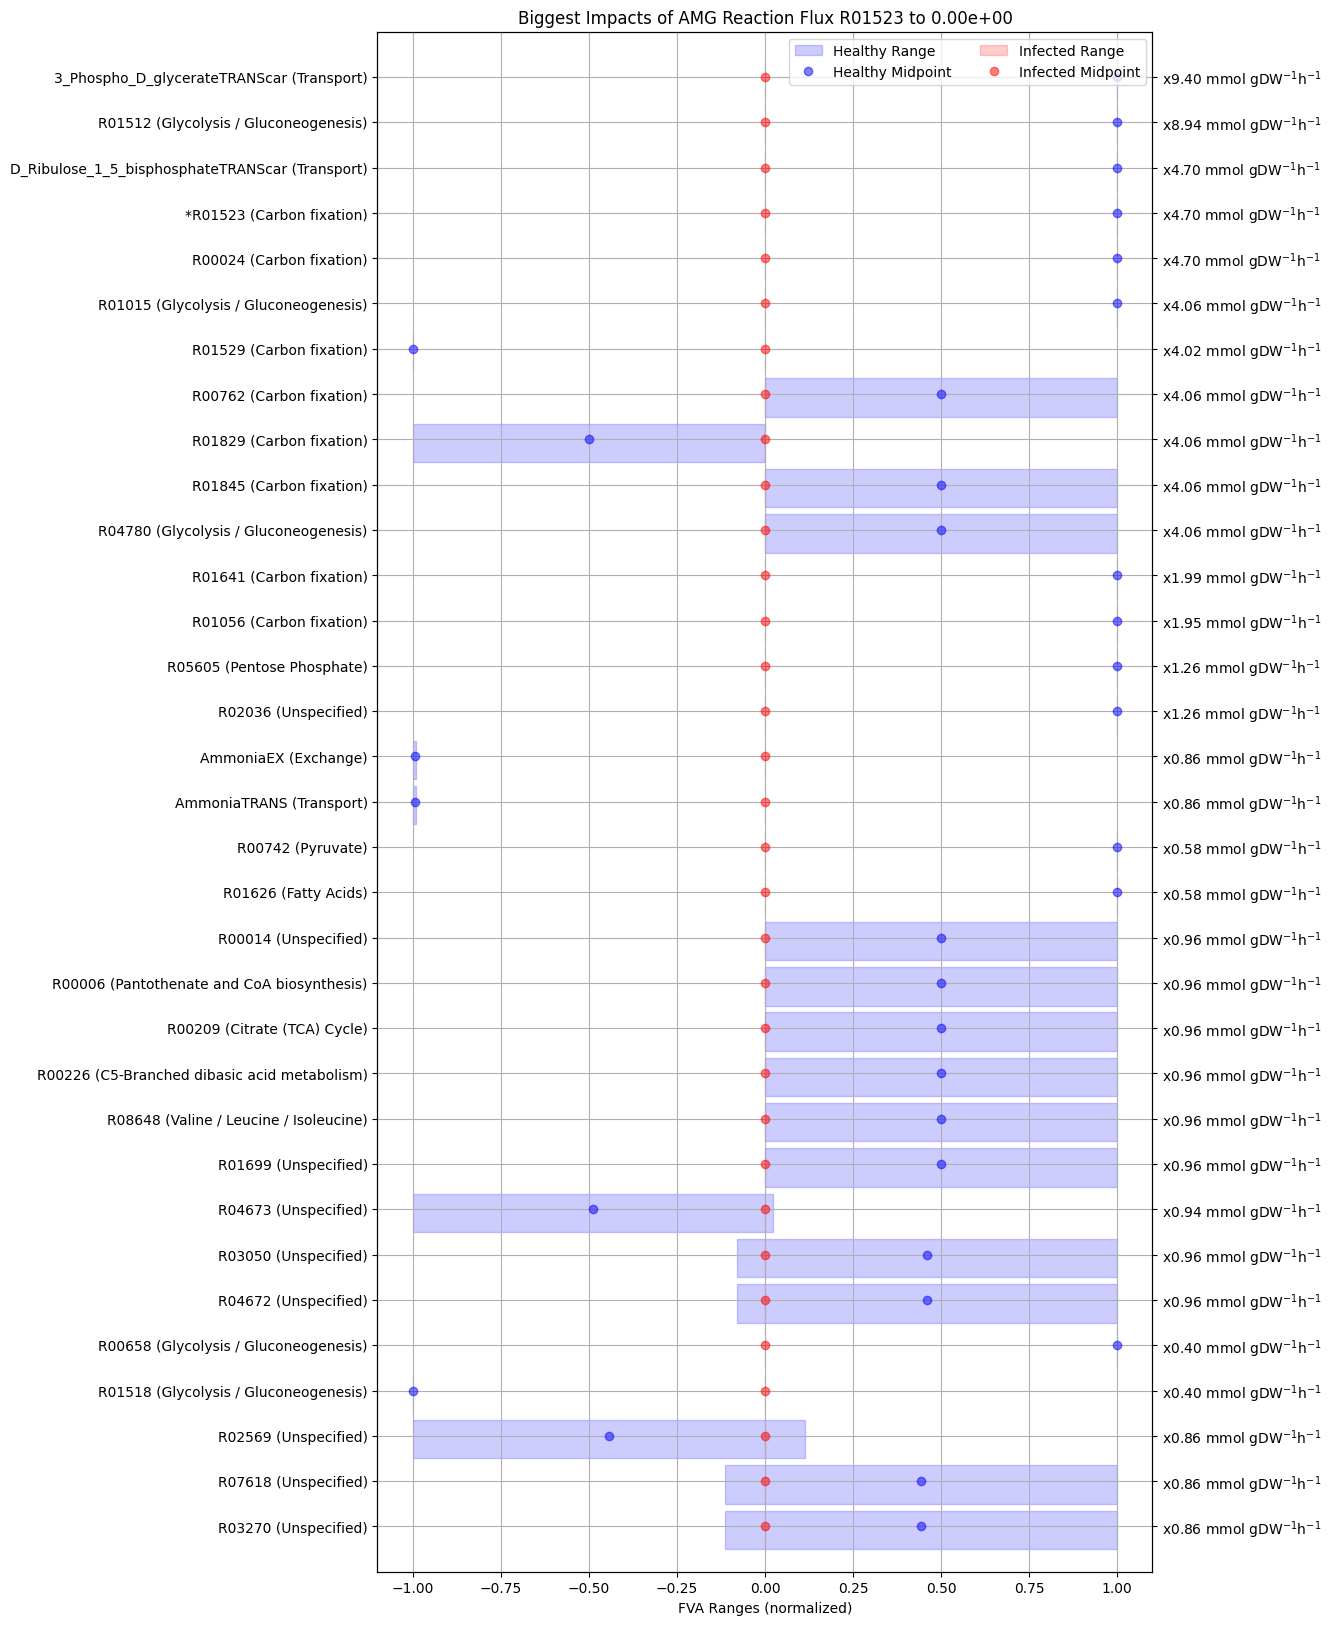

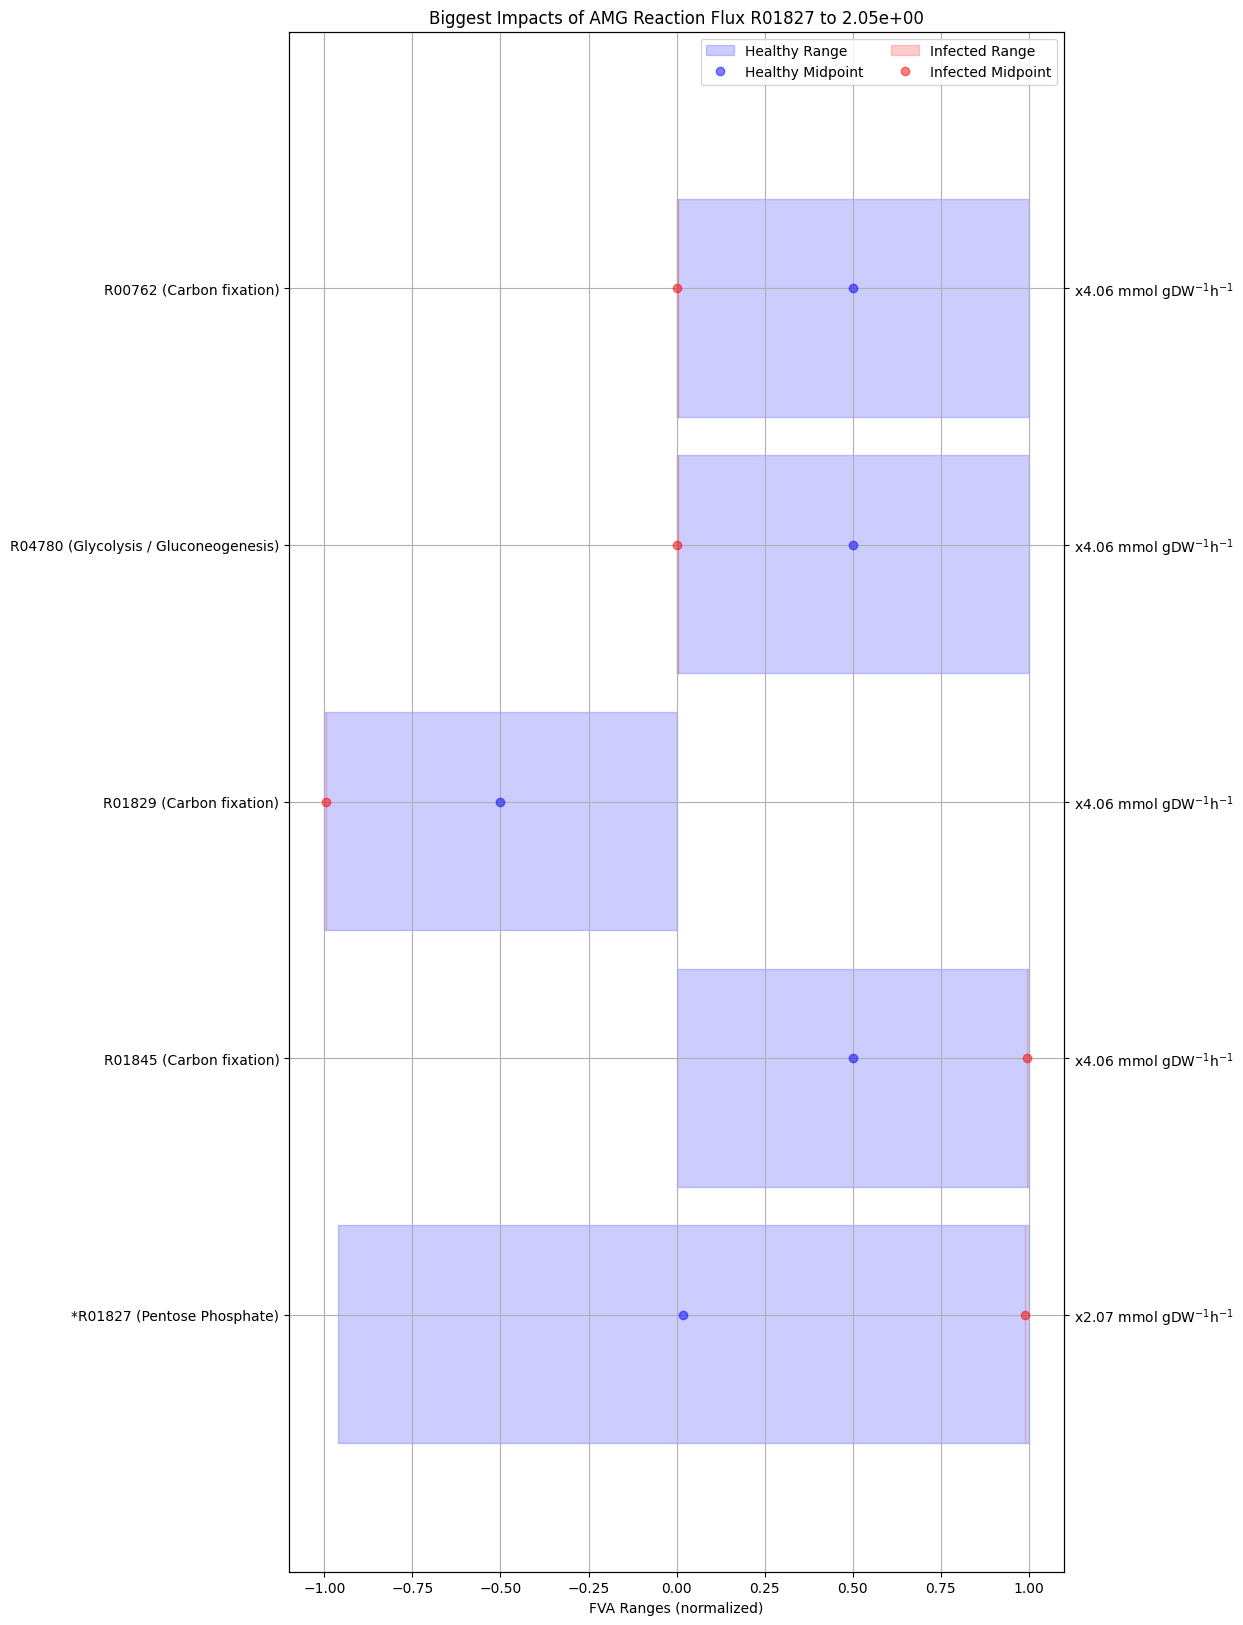

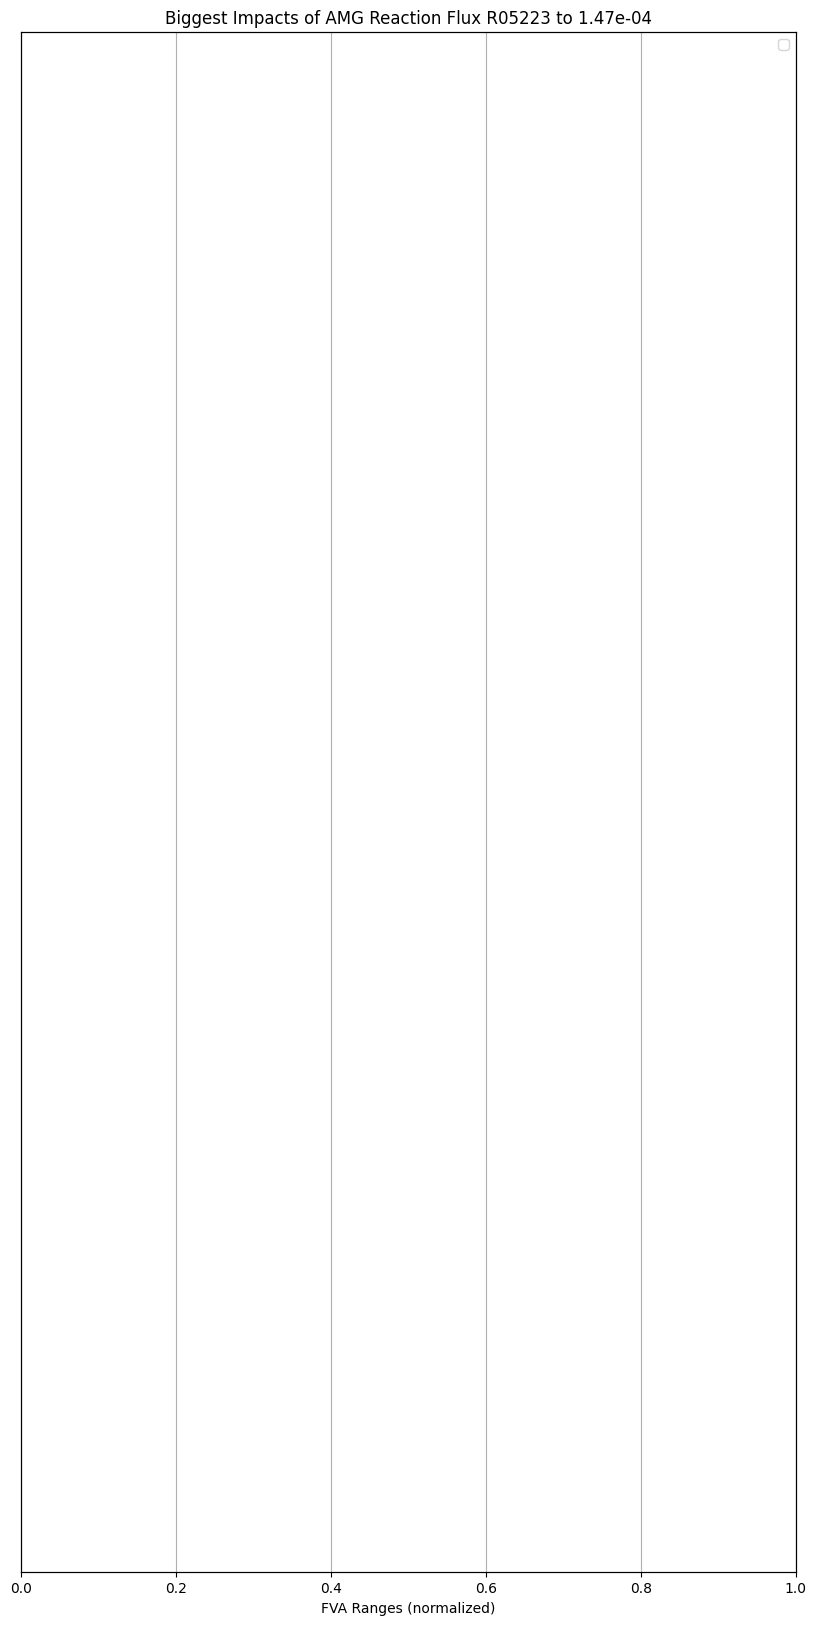

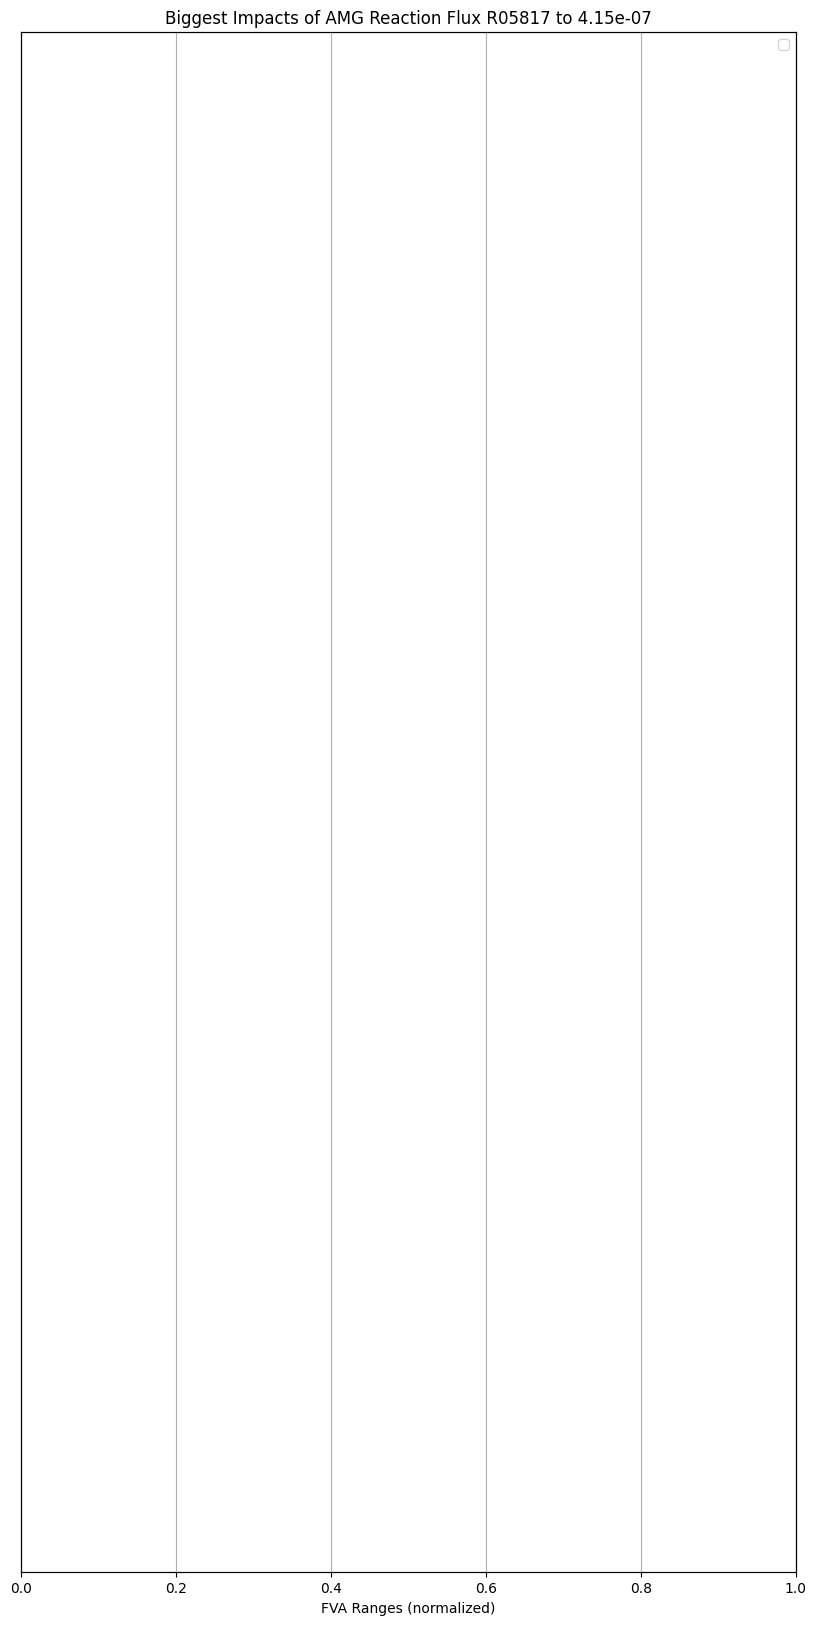

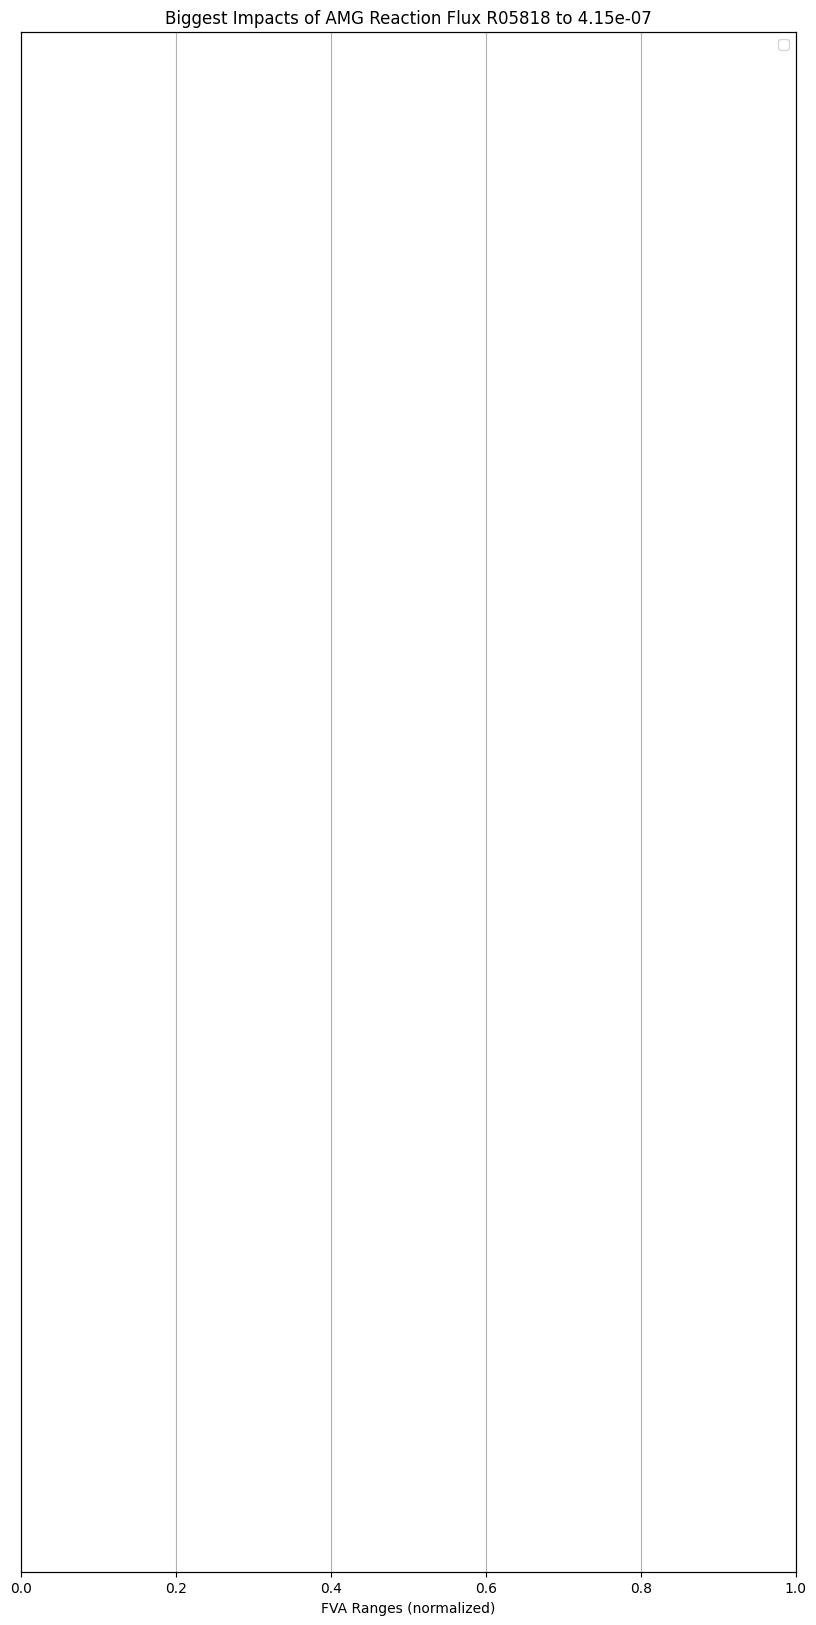

In [16]:
amg_fvas = {}
for amg, new_val in amg_new_vals.items():
    with model as phm2:
        phm2.reactions.get_by_id(amg).bounds = new_val, new_val
        fva_phm2 = cobra.flux_analysis.flux_variability_analysis(phm2)
    amg_fvas[amg] = fva_phm2.copy()
    fig, ax = plt.subplots(1, 1, figsize=(10, 20))
    plot_impact_graph(ax, fva_healthy, fva_phm2, amgs, cut=0.25)
    ax.set_title(f"Biggest Impacts of AMG Reaction Flux {amg} to {new_val:.2e}")
    plt.show()

In [17]:
hmid = (fva_healthy["maximum"] + fva_healthy["minimum"]) / 2
mdiffs = {}
for amg, fva in sorted(amg_fvas.items()):
    mids = (fva["maximum"] + fva["minimum"]) / 2
    mid_diff = mids - hmid
    mdiffs[amg] = mid_diff
mdf = pd.DataFrame(mdiffs)

In [18]:
mdf_filtered = mdf[mdf.abs().max(axis=1) >= 0.01].apply(lambda x: x)
mdf_filtered["Phage Biomass"] = (
    fva_phm2_no_amg["maximum"] + fva_phm2_no_amg["minimum"]
) / 2 - hmid

mdf_filtered = mdf_filtered.sort_index(
    axis=0,
    key=lambda x: [model.reactions.get_by_id(y).subsystem for y in x],
)
last = ""
switch_inds = [(0, "Unspecified")]
for i, (rxn, row) in enumerate(mdf_filtered.iterrows()):
    ss = model.reactions.get_by_id(rxn).subsystem
    if last != ss:
        last = ss
        if ss in manual_relabels:
            ss = manual_relabels[ss]
        switch_inds.append((i, ss))
switch_inds

[(0, 'Unspecified'),
 (58, 'Alanine, aspartate and glutamate metabolism'),
 (61, 'Arginine / Proline'),
 (71, 'Biomass'),
 (74, 'C5-Branched dibasic acid metabolism'),
 (75, 'Carbon fixation'),
 (85, 'Citrate (TCA) Cycle'),
 (94, 'Cysteine and methionine metabolism'),
 (99, 'Exchange'),
 (118, 'Fatty Acids'),
 (154, 'Galactose metabolism'),
 (155, 'Glutathione'),
 (161, 'Glycerolipids'),
 (168, 'Glycine / Serine / Threonine'),
 (184, 'Glycolysis / Gluconeogenesis'),
 (195, 'Histidine'),
 (203, 'Lysine biosynthesis'),
 (208, 'Nicotinate / Nicotinamide'),
 (211, 'Nitrogen metabolism'),
 (214, 'One carbon pool by folate'),
 (220, 'Oxidative Phosphorylation'),
 (232, 'Pantothenate and CoA biosynthesis'),
 (235, 'Pentose Phosphate'),
 (241, 'Phenylalanine / Tyrosine / Tryptophan'),
 (250, 'Photorespiration'),
 (252, 'Photosynthesis'),
 (262, 'Porphyrin / Chlorophyll'),
 (269, 'Purine'),
 (298, 'Pyrimidine'),
 (330, 'Pyruvate'),
 (336, 'Selenocompound metabolism'),
 (340, 'Starch and sucrose

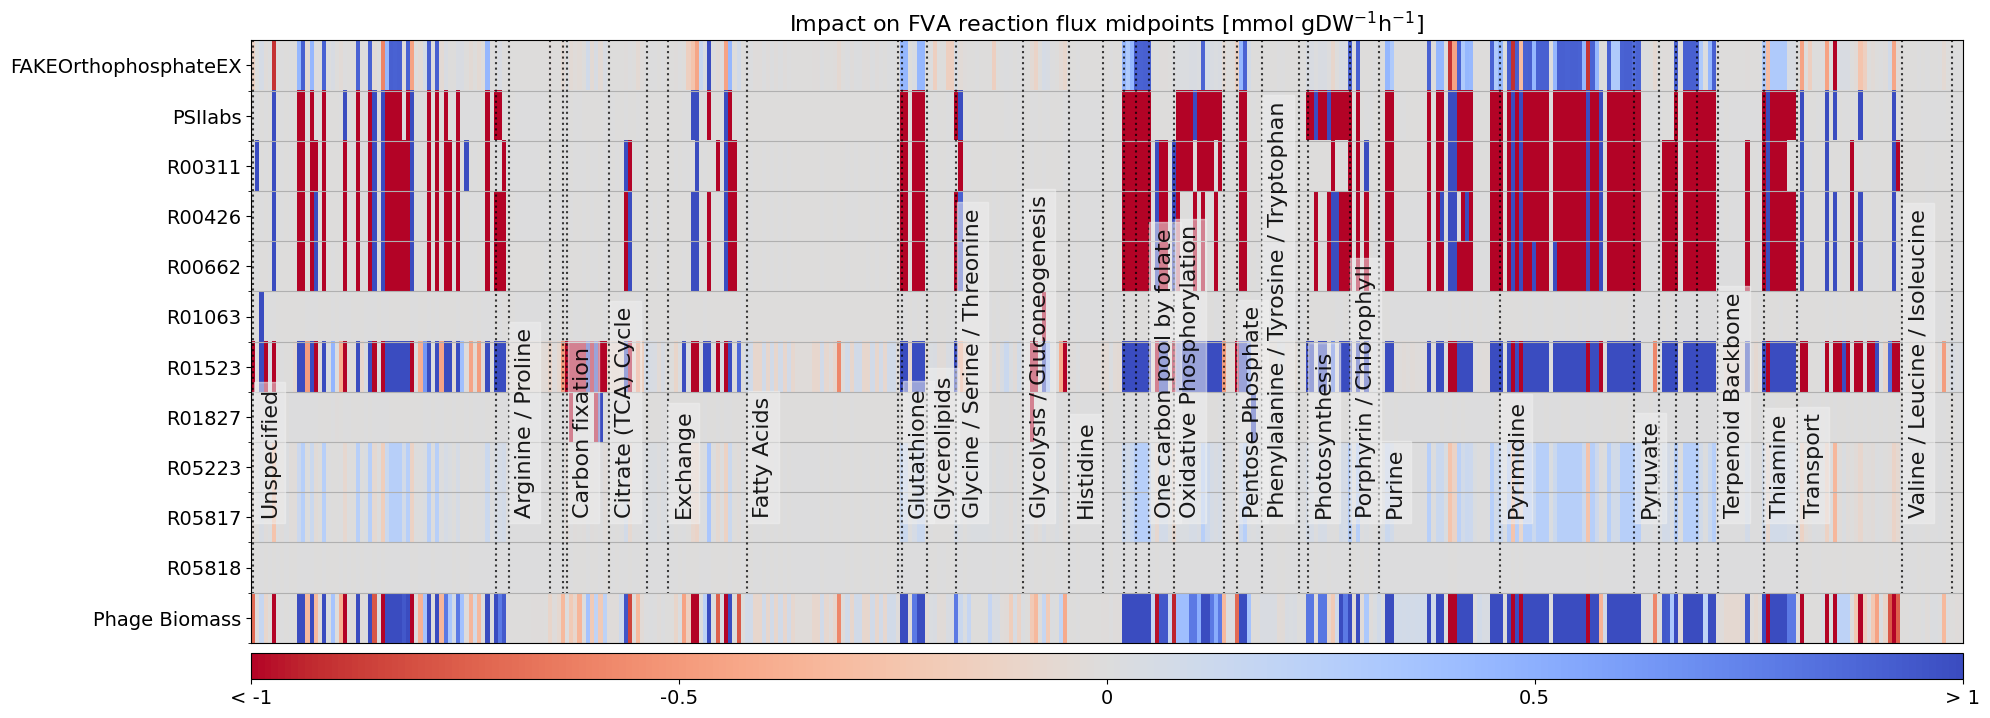

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
im = ax.matshow(
    mdf_filtered.T,
    cmap="coolwarm_r",
    vmin=-1,
    vmax=1,
    aspect=12,
    interpolation="none",
)
ticks = range(1 + len(sorted(amgs.keys())))

ax.set_yticks(ticks, minor=False)
ax.set_yticks([0.5 + x for x in ticks], minor=True)
ax.set_yticklabels(sorted(amgs.keys()) + ["Phage Biomass"], fontsize=14)
ax.set_xticks([])
ax.grid(True, which="minor")
ax.set_title(
    "Impact on FVA reaction flux midpoints " + r"[mmol gDW$^{-1}$h$^{-1}$]", fontsize=16
)
cbar = fig.colorbar(
    im,
    aspect=64,
    orientation="horizontal",
    pad=0.01,
)
cbar.set_ticks(
    ticks=[-1, -0.5, 0, 0.5, 1],
    labels=["< -1", "-0.5", "0", "0.5", "> 1"],
    fontsize=14,
)


for line, (i, ss) in enumerate(switch_inds):
    if ss == "":
        ss = "Unspecified"
    ax.vlines(i, -0.5, 10.5, linestyles="dotted", color="black", alpha=0.75)
    if (line < len(switch_inds) - 1) and switch_inds[line + 1][0] - i > 5:
        ax.text(
            i + 1.5,
            9.0,
            ss,
            horizontalalignment="left",
            verticalalignment="bottom",
            fontsize=16,
            rotation=90,
            color="black",
            alpha=0.9,
            backgroundcolor="#f0f0f088",
        )


fig.tight_layout()
# fig.savefig("phage_barcode.png")
plt.show()